# `British Airways Customer Reviews Sentimental Analysis`

In this task, we will be doing some sentimental analysis using python on British Airways(BA) customer reviews extracted from value [Skytrax](https://www.airlinequality.com/) using Roberta Pretrained Model from [HuggingFace](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment).

### `Step 1: Import libraries and NLTK Basics`

In [3]:
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize


#### `Step 2: Import and wrangle data`

In [58]:
# wrangle function
def wrangle(data_path): 
    # Read in csv data file using pandas
    df = pd.read_csv(data_path)
    
    # Drop customer names 
    df = df.drop(columns=["name"])
    
    # Select only verified customers
    df = df[(df["verification"] == "Trip Verified")|(df["verification"] == "Verified Review")]
    
    # Replace NaN with 0 in specific columns 
    cols_to_fill = ['cabin staff service', 'food and beverages', 'value for money']  # Columns to replace NaN with 0
    df[cols_to_fill] = df[cols_to_fill].fillna(0)
    
    # Changing data types
    df["cabin staff service"] = df["cabin staff service"].astype(int)
    df["food and beverages"] = df["food and beverages"].astype(int)
    df["value for money"] = df["value for money"].astype(int)
    
    df['review summary'] = df['review summary'].str.strip('“”""')
    
    # Reset index
    df = df.reset_index(drop=True)
    
    
    
    return df

In [59]:
df = wrangle("ba_reviews.csv")
print(df.shape)
df.head()


(2013, 13)


,date,country,verification,review summary,body,aircraft,traveller type,seat type,route,cabin staff service,food and beverages,value for money,recommend
0,30/06/2024,United Kingdom,Trip Verified,wholly inadequate customer service,Flight cancelled with no reason given less tha...,NaN,Couple Leisure,Economy Class,London Gatwick to Verona,1,1,1,no
1,26/06/2024,United Kingdom,Trip Verified,the cabin crew were great,This is a route I fly regularly. Used first cl...,A320,Business,Business Class,London Heathrow to Paris CDG,5,3,3,yes
2,23/06/2024,Canada,Trip Verified,cannot recommend BA,While BA may have made some positive improveme...,A350-1000,Solo Leisure,Economy Class,London Heathrow to Vancouver,2,1,1,no
3,23/06/2024,Canada,Trip Verified,a very poor last impression of BA,British Airways new Club Suite is a marked imp...,A350-1000,Solo Leisure,Business Class,Vancouver to London Heathrow,3,3,2,no
4,18/06/2024,United Kingdom,Trip Verified,happy to recommend BA,"Four very pleasant, on time flights with frien...",A320/A380,Couple Leisure,Business Class,Belfast to San Francisco via London,5,3,4,yes


In [66]:
df['aircraft'].value_counts()

aircraft
A320                     263
Boeing 777               166
A380                     117
Boeing 747-400            95
Boeing 777-200            78
                        ... 
A320/A319                  1
A321 / Boeing 747-400      1
SAAB 2000                  1
A380 / Boeing 747-400      1
Boeing 747-400 /A380       1
Name: count, Length: 149, dtype: int64

#### `Step 3: Exploratory Data Analysis`

Bar and Pie Charts to show numerical summary of reviews

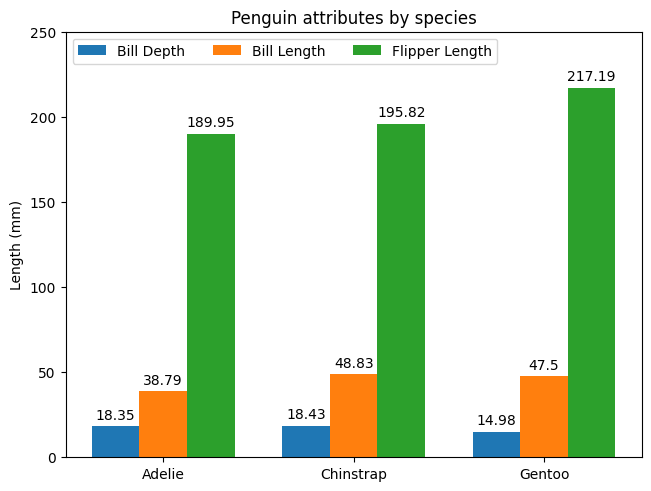

In [93]:
import matplotlib.pyplot as plt
import numpy as np

species = ("Adelie", "Chinstrap", "Gentoo")
penguin_means = {
    'Bill Depth': (18.35, 18.43, 14.98),
    'Bill Length': (38.79, 48.83, 47.50),
    'Flipper Length': (189.95, 195.82, 217.19),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250)

plt.show()

In [94]:
# Value counts for numerical columns
cabin_staff_service_count = df["cabin staff service"].value_counts().sort_index()
food_count =  df["food and beverages"].value_counts().sort_index()
value_for_money_count = df["value for money"].value_counts().sort_index()

In [127]:
points_review_cols_list = []
for col in [cabin_staff_service_count, food_count, value_for_money_count]:
  points_review_cols_list.append(col.values.tolist())
  
  
print(points_review_cols_list[0][5])

481


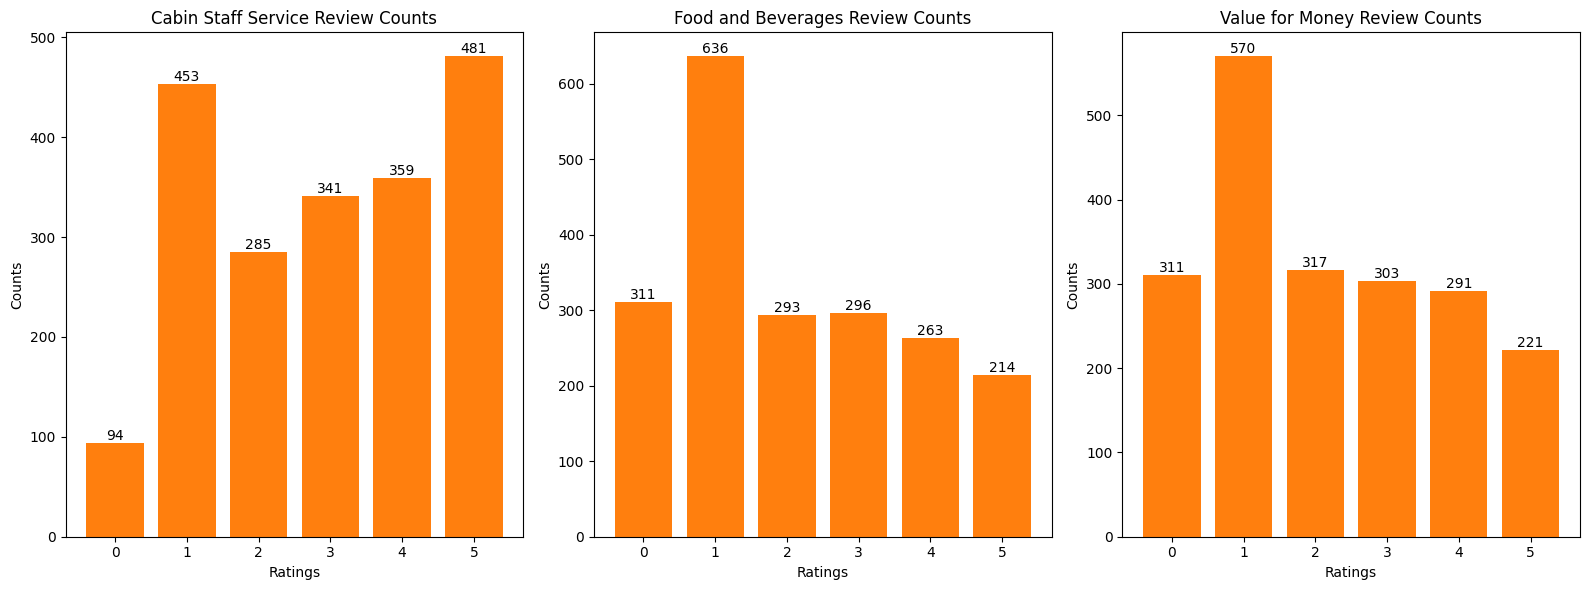

In [155]:

# Value counts for numerical columns
cabin_staff_service_count = df["cabin staff service"].value_counts().sort_index()
food_count =  df["food and beverages"].value_counts().sort_index()
value_for_money_count = df["value for money"].value_counts().sort_index()

# Create a figure with 1 row, 3 columns
fig, axs = plt.subplots(1,3, figsize=(16,6))

# Cabin staff service review counts
axs[0].bar(cabin_staff_service_count.index,  cabin_staff_service_count.values)
axs[0].set_title('Cabin Staff Service Review Counts')
axs[0].set_xlabel('Ratings')
axs[0].set_ylabel('Counts')
axs[0].set_xticks(cabin_staff_service_count.index)

# Food and beverages review count
axs[1].bar(food_count.index, food_count.values )
axs[1].set_title('Food and Beverages Review Counts')
axs[1].set_xlabel('Ratings')
axs[1].set_ylabel('Counts')
axs[1].set_xticks(food_count.index)

# Value for money review count
axs[2].bar(value_for_money_count.index, value_for_money_count.values)
axs[2].set_title('Value for Money Review Counts')
axs[2].set_xlabel('Ratings')
axs[2].set_ylabel('Counts')
axs[2].set_xticks(value_for_money_count.index)

# Loop through subplots and data
for i, col_data in enumerate(zip(axs, [cabin_staff_service_count, food_count, value_for_money_count])):
  ax = col_data[0]  # Access subplot
  col_data = col_data[1]  # Access data
  ax.bar(col_data.index, col_data.values)
  ax.bar_label(ax.containers[0])  # Assuming a single container for bars in each subplot

plt.tight_layout()


plt.show()



In [61]:
df.dtypes

date                   object
country                object
verification           object
review summary         object
body                   object
aircraft               object
traveller type         object
seat type              object
route                  object
cabin staff service     int64
food and beverages      int64
value for money         int64
recommend              object
dtype: object